In [ ]:
#Guide Link
Followed the following: https://github.com/offirinbar/NYC_Taxi/blob/master/NYC_Taxi_PyTorch.ipynb

In [1]:
## import libraries

#PyTorch 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
from torchvision import models
from torch.nn import init
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch.optim import lr_scheduler

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing


#other
from IPython.core.debugger import set_trace
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
import math 
from google.colab import files
import io
import datetime as dt
import re
import pandas_profiling
import pandas_profiling as pp
from math import sqrt

#graphs
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import pylab as plt
import matplotlib.dates as dates
import seaborn as sns
import pylab
import matplotlib
import matplotlib.dates
from IPython.display import display
import plotly.graph_objects as go


%matplotlib inline

In [2]:
# load tqdm
#!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
from tqdm import tqdm, tqdm_notebook, tnrange

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [4]:

# upload df_train csv file

uploaded = files.upload()
df_train = pd.read_csv(io.BytesIO(uploaded['sub_train.csv']))
df_train.head()

Saving sub_train.csv to sub_train.csv


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2012-10-06 20:31:36.0000003,5.5,2012-10-06 20:31:36 UTC,-73.952825,40.772048,-73.952194,40.781152,3
1,1,2010-07-12 09:44:33.0000001,4.9,2010-07-12 09:44:33 UTC,-73.983249,40.734655,-73.991278,40.738918,1
2,2,2010-05-07 20:05:00.000000228,14.9,2010-05-07 20:05:00 UTC,-73.968212,40.762212,-73.919958,40.755087,2
3,3,2010-05-31 18:05:00.00000060,6.9,2010-05-31 18:05:00 UTC,-73.991633,40.750440,-73.985928,40.736168,3
4,4,2011-11-03 17:35:00.00000095,7.7,2011-11-03 17:35:00 UTC,-73.978593,40.753452,-73.978652,40.762660,1


In [5]:
df_train.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2012-10-06 20:31:36.0000003,5.5,2012-10-06 20:31:36 UTC,-73.952825,40.772048,-73.952194,40.781152,3
1,1,2010-07-12 09:44:33.0000001,4.9,2010-07-12 09:44:33 UTC,-73.983249,40.734655,-73.991278,40.738918,1
2,2,2010-05-07 20:05:00.000000228,14.9,2010-05-07 20:05:00 UTC,-73.968212,40.762212,-73.919958,40.755087,2
3,3,2010-05-31 18:05:00.00000060,6.9,2010-05-31 18:05:00 UTC,-73.991633,40.750440,-73.985928,40.736168,3
4,4,2011-11-03 17:35:00.00000095,7.7,2011-11-03 17:35:00 UTC,-73.978593,40.753452,-73.978652,40.762660,1


In [6]:
# upload df_Test csv file

uploaded = files.upload()
df_test = pd.read_csv(io.BytesIO(uploaded['test.csv']))
df_test.head()

Saving test.csv to test.csv


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [7]:
df_test_for_sub = df_test['key']
df_test_for_sub

0       2015-01-27 13:08:24.0000002
1       2015-01-27 13:08:24.0000003
2       2011-10-08 11:53:44.0000002
3       2012-12-01 21:12:12.0000002
4       2012-12-01 21:12:12.0000003
                   ...             
9909    2015-05-10 12:37:51.0000002
9910    2015-01-12 17:05:51.0000001
9911    2015-04-19 20:44:15.0000001
9912    2015-01-31 01:05:19.0000005
9913    2015-01-18 14:06:23.0000006
Name: key, Length: 9914, dtype: object

In [8]:
# delete the fares that are less than 0
df_train = df_train.loc[df_train.fare_amount > 0]
df_train.fare_amount.min()

0.01

In [9]:
len(df_train)

99994

In [10]:
train_X = df_train.drop(columns=['fare_amount'])
Y = np.log(df_train.fare_amount)

#Y = df_train['fare_amount']
test_X = df_test

In [11]:
df = train_X.append(test_X,sort=False)


In [12]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,Unnamed: 0,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,0.0,2012-10-06 20:31:36.0000003,2012-10-06 20:31:36 UTC,-73.952825,40.772048,-73.952194,40.781152,3,1.013712
1,1.0,2010-07-12 09:44:33.0000001,2010-07-12 09:44:33 UTC,-73.983249,40.734655,-73.991278,40.738918,1,0.826026
2,2.0,2010-05-07 20:05:00.000000228,2010-05-07 20:05:00 UTC,-73.968212,40.762212,-73.919958,40.755087,2,4.140762
3,3.0,2010-05-31 18:05:00.00000060,2010-05-31 18:05:00 UTC,-73.991633,40.750440,-73.985928,40.736168,3,1.658157
4,4.0,2011-11-03 17:35:00.00000095,2011-11-03 17:35:00 UTC,-73.978593,40.753452,-73.978652,40.762660,1,1.023895


In [13]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,Unnamed: 0,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,0.0,2012-10-06 20:31:36.0000003,2012-10-06 20:31:36 UTC,-73.952825,40.772048,-73.952194,40.781152,3,1.013712,2012-10-06 16:31:36,16,pm,Sat
1,1.0,2010-07-12 09:44:33.0000001,2010-07-12 09:44:33 UTC,-73.983249,40.734655,-73.991278,40.738918,1,0.826026,2010-07-12 05:44:33,5,am,Mon
2,2.0,2010-05-07 20:05:00.000000228,2010-05-07 20:05:00 UTC,-73.968212,40.762212,-73.919958,40.755087,2,4.140762,2010-05-07 16:05:00,16,pm,Fri
3,3.0,2010-05-31 18:05:00.00000060,2010-05-31 18:05:00 UTC,-73.991633,40.750440,-73.985928,40.736168,3,1.658157,2010-05-31 14:05:00,14,pm,Mon
4,4.0,2011-11-03 17:35:00.00000095,2011-11-03 17:35:00 UTC,-73.978593,40.753452,-73.978652,40.762660,1,1.023895,2011-11-03 13:35:00,13,pm,Thu


In [14]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']

In [15]:
#make the cat categories as "category" and label encoder it.
for col in df.columns:
  if col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])
    df[col]= df[col].astype('category')

In [16]:
df.head()


,Unnamed: 0,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,0.0,2012-10-06 20:31:36.0000003,2012-10-06 20:31:36 UTC,-73.952825,40.772048,-73.952194,40.781152,3,1.013712,2012-10-06 16:31:36,16,1,2
1,1.0,2010-07-12 09:44:33.0000001,2010-07-12 09:44:33 UTC,-73.983249,40.734655,-73.991278,40.738918,1,0.826026,2010-07-12 05:44:33,5,0,1
2,2.0,2010-05-07 20:05:00.000000228,2010-05-07 20:05:00 UTC,-73.968212,40.762212,-73.919958,40.755087,2,4.140762,2010-05-07 16:05:00,16,1,0
3,3.0,2010-05-31 18:05:00.00000060,2010-05-31 18:05:00 UTC,-73.991633,40.750440,-73.985928,40.736168,3,1.658157,2010-05-31 14:05:00,14,1,1
4,4.0,2011-11-03 17:35:00.00000095,2011-11-03 17:35:00 UTC,-73.978593,40.753452,-73.978652,40.762660,1,1.023895,2011-11-03 13:35:00,13,1,4


In [17]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 109908 entries, 0 to 9913
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Unnamed: 0         99994 non-null   float64       
 1   key                109908 non-null  object        
 2   pickup_datetime    109908 non-null  object        
 3   pickup_longitude   109908 non-null  float64       
 4   pickup_latitude    109908 non-null  float64       
 5   dropoff_longitude  109908 non-null  float64       
 6   dropoff_latitude   109908 non-null  float64       
 7   passenger_count    109908 non-null  int64         
 8   dist_km            109908 non-null  float64       
 9   EDTdate            109908 non-null  datetime64[ns]
 10  Hour               109908 non-null  category      
 11  AMorPM             109908 non-null  category      
 12  Weekday            109908 non-null  category      
dtypes: category(3), datetime64[ns](1), float64(6),

In [18]:
df.columns


Index(['Unnamed: 0', 'key', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [19]:
# keep only the cols for the model
df = df[['Hour', 'AMorPM', 'Weekday','pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']]


In [20]:
df_train = df[:99994]
df_test = df[99994:]

In [21]:
#Normalizing 

from pandas.api.types import is_numeric_dtype

#"Compute the means and stds of `self.cont_names` columns to normalize them."
def Normalize(df):
  means,stds = {},{}
  cont_names = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
  for n in cont_names:
    assert is_numeric_dtype(df[n]), (f"""Cannot normalize '{n}' column as it isn't numerical. Are you sure it doesn't belong in the categorical set of columns?""")
    means[n],stds[n] = df[n].mean(),df[n].std()
    df[n] = (df[n]-means[n]) / (1e-7 + stds[n])


Normalize(df_train)
Normalize(df_test)
X = df_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
df_train.head()


,Hour,AMorPM,Weekday,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,dist_km
0,16,1,2,0.130818,-0.118696,0.124782,-0.121001,0.895281,-0.051084
1,5,0,1,0.125184,-0.121194,0.118571,-0.124307,-0.471509,-0.051581
2,16,1,0,0.129336,-0.119959,0.120949,-0.118275,0.211886,-0.042799
3,14,1,1,0.127562,-0.121883,0.118167,-0.123854,0.895281,-0.049376
4,13,1,4,0.128016,-0.120812,0.122062,-0.123239,-0.471509,-0.051057


In [23]:
X.shape


(99994, 9)

In [24]:
X.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 99994 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Hour               99994 non-null  category
 1   AMorPM             99994 non-null  category
 2   Weekday            99994 non-null  category
 3   pickup_latitude    99994 non-null  float64 
 4   pickup_longitude   99994 non-null  float64 
 5   dropoff_latitude   99994 non-null  float64 
 6   dropoff_longitude  99994 non-null  float64 
 7   passenger_count    99994 non-null  float64 
 8   dist_km            99994 non-null  float64 
dtypes: category(3), float64(6)
memory usage: 5.6 MB


In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=42,shuffle=True ) 
X_train.head()


,Hour,AMorPM,Weekday,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,dist_km
38242,11,0,3,0.127318,-0.123118,0.115867,-0.123806,-0.471509,-0.044170
3806,12,1,1,0.124350,-0.122392,0.117958,-0.125756,0.211886,-0.050886
27928,15,1,1,0.125222,-0.122093,0.110901,-0.122894,-0.471509,-0.038923
6006,7,0,4,0.130481,-0.119716,0.122279,-0.122430,-0.471509,-0.051888
65809,14,1,3,0.131605,-0.120822,0.122593,-0.123915,-0.471509,-0.050077


In [26]:
#df.info()
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [27]:
type(emb_szs)


list

In [28]:
X_train.shape


(79995, 9)

In [29]:
X_val.shape


(19999, 9)

In [30]:
y_train.shape


(79995,)

In [31]:
y_val.shape


(19999,)

In [32]:
class RegressionColumnarDataset(data.Dataset):
    def __init__(self, df, cats, y):
        
        
        self.dfcats = df[cats] #type: pandas.core.frame.DataFrame
        self.dfconts = df.drop(cats, axis=1) #type: pandas.core.frame.DataFrame
        
        
        self.cats = np.stack([c.values for n, c in self.dfcats.items()], axis=1).astype(np.int64) #tpye: numpy.ndarray
        self.conts = np.stack([c.values for n, c in self.dfconts.items()], axis=1).astype(np.float32) #tpye: numpy.ndarray
        self.y = y.values.astype(np.float32)
        
        
    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        
        return [self.cats[idx], self.conts[idx], self.y[idx]]

In [33]:
trainds = RegressionColumnarDataset(X_train, cat_cols, y_train) #type: __main__.RegressionColumnarDataset
valds = RegressionColumnarDataset(X_val, cat_cols, y_val) #type: __main__.RegressionColumnarDataset

In [34]:
params = {'batch_size': 128,
          'shuffle': True}


traindl = DataLoader(trainds, **params) #type: torch.utils.data.dataloader.DataLoader
valdl = DataLoader(valds, **params) #type: torch.utils.data.dataloader.DataLoader

In [35]:
# help functions

from collections.abc import Iterable


def bn_drop_lin(n_in:int, n_out:int, bn:bool=True, p:float=0., actn=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

def ifnone(a,b):
    "`a` if `a` is not None, otherwise `b`."
    return b if a is None else a

def listify(p, q):
    "Make `p` listy and the same length as `q`."
    if p is None: p=[]
    elif isinstance(p, str):          p = [p]
    elif not isinstance(p, Iterable): p = [p]
    #Rank 0 tensors in PyTorch are Iterable but don't have a length.
    else:
        try: a = len(p)
        except: p = [p]
    n = q if type(q)==int else len(p) if q is None else len(q)
    if len(p)==1: p = p * n
    assert len(p)==n, f'List len mismatch ({len(p)} vs {n})'
    return list(p)

              

class TabularModel(nn.Module):
    "Basic model for tabular data."
    def __init__(self, emb_szs, n_cont:int, out_sz:int, layers, ps=None,
                 emb_drop:float=0., y_range=None, use_bn:bool=True, bn_final:bool=False):
        super().__init__()
        ps = ifnone(ps, [0]*len(layers))
        ps = listify(ps, layers)
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs]) #type: torch.nn.modules.container.ModuleList
        self.emb_drop = nn.Dropout(emb_drop) #type: torch.nn.modules.dropout.Dropout
        self.bn_cont = nn.BatchNorm1d(n_cont) #type torch.nn.modules.batchnorm.BatchNorm1d
        n_emb = sum(e.embedding_dim for e in self.embeds) # n_emb = 17 , type: int
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        sizes = [n_emb + n_cont] + layers + [out_sz] #typeL list, len: 4
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None] #type: list, len: 3.  the last in None because we finish with linear
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers) #type: torch.nn.modules.container.Sequential
        



    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)] #take the embedding list and grab an embedding and pass in our single row of data.        
            x = torch.cat(x, 1) # concatenate it on dim 1 ## remeber that the len is the batch size
            x = self.emb_drop(x) # pass it through a dropout layer
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont) # batchnorm1d
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont # combine the categircal and continous variables on dim 1
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0] # deal with y_range
        return x.squeeze()

In [36]:
torch.manual_seed(33)


In [37]:
y_range = (0, y_train.max()*1.2)
y_range


(0, 6.963592949672579)

In [38]:
model = TabularModel(emb_szs = emb_szs,n_cont = len(cont_cols),out_sz = 1,layers = [1000,500,250],ps= [0.001,0.01,0.01],emb_drop=0.04, y_range=y_range).to(device)
model


TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01, inplace=False)
    (8): Linear(in_features=500, out_features=250, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.01, inplace=False)
    (12): Linear(in_features=250, out_features=1, bias=

In [39]:
from collections import defaultdict
opt = torch.optim.Adam(model.parameters(), lr=1e-2) # can add: weight_decay=
#lr_cosine = lr_scheduler.CosineAnnealingLR(opt,T_max = 350) #1000 ## if you want to add lr_cosine



lr = defaultdict(list)
tloss = defaultdict(list)
vloss = defaultdict(list)

In [40]:
def inv_y(y): return np.exp(y)

def rmse(targ, y_pred):
    return np.sqrt(mean_squared_error(inv_y(y_pred), inv_y(targ))) #.detach().numpy()
    

def rmse(targ, y_pred):
   return np.sqrt(mean_squared_error(y_pred, targ)) #.detach().numpy()


#def fit(model, train_dl, val_dl, loss_fn, opt, scheduler, epochs=3): ## if you want to add schedular
def fit(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    num_batch = len(train_dl)
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0          
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for cat, cont, y in t:
            cat = cat.cuda()
            cont = cont.cuda()
            y = y.cuda()
            
            t.set_description(f'Epoch {epoch}')
            
            opt.zero_grad() #find where the grads are zero
            pred = model(cat, cont)
            loss = loss_fn(pred, y)
            
            loss.backward() # do backprop
            lr[epoch].append(opt.param_groups[0]['lr'])
            tloss[epoch].append(loss.item())
            opt.step()
            #scheduler.step()
            
            
            t.set_postfix(loss=loss.item())
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred.cpu().data.numpy())
            total_loss_train += loss.item()
            
        train_acc = rmse(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl) # len train_dl = 704. the calc is number of train examples (89991) / batch size (128)
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for cat, cont, y in tqdm_notebook(val_dl, leave=False):
                cat = cat.cuda()
                cont = cont.cuda()
                y = y.cuda()
                pred = model(cat, cont)
                loss = loss_fn(pred, y)
                
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred.cpu().data.numpy())
                total_loss_val += loss.item()
                vloss[epoch].append(loss.item())
            valacc = rmse(y_true_val, y_pred_val)
            valloss = total_loss_val/len(valdl)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f} | val_loss: {valloss:.4f} val_rmse: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f}')
    
    return lr, tloss, vloss

In [41]:
#if you want to add lr_cosine
#lr, tloss, vloss = fit(model=model, train_dl=traindl, val_dl=valdl, loss_fn=nn.MSELoss(), opt=opt, scheduler=lr_cosine, epochs=10)


lr, tloss, vloss = fit(model=model, train_dl=traindl, val_dl=valdl, loss_fn=nn.MSELoss(), opt=opt,  epochs=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning:

Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 0: train_loss: 0.3385 train_rmse: 0.5818 | val_loss: 0.1906 val_rmse: 0.4371


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 1: train_loss: 0.1788 train_rmse: 0.4229 | val_loss: 0.1819 val_rmse: 0.4269


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 2: train_loss: 0.1462 train_rmse: 0.3823 | val_loss: 0.1269 val_rmse: 0.3567


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 3: train_loss: 0.1132 train_rmse: 0.3365 | val_loss: 0.1099 val_rmse: 0.3315


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 4: train_loss: 0.1056 train_rmse: 0.3250 | val_loss: 0.1089 val_rmse: 0.3301


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 5: train_loss: 0.1073 train_rmse: 0.3275 | val_loss: 0.1062 val_rmse: 0.3262


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 6: train_loss: 0.1038 train_rmse: 0.3222 | val_loss: 0.1035 val_rmse: 0.3218


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 7: train_loss: 0.1038 train_rmse: 0.3221 | val_loss: 0.1022 val_rmse: 0.3190


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 8: train_loss: 0.1033 train_rmse: 0.3213 | val_loss: 0.1057 val_rmse: 0.3246


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 9: train_loss: 0.1035 train_rmse: 0.3217 | val_loss: 0.0998 val_rmse: 0.3160



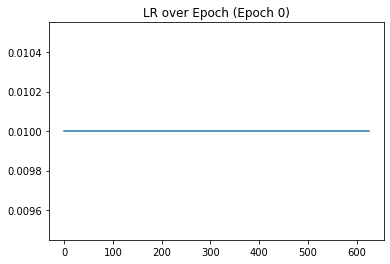

In [42]:
#Plot the Learning rate
_ = plt.plot(lr[0])
_ = plt.title('LR over Epoch (Epoch 0)')


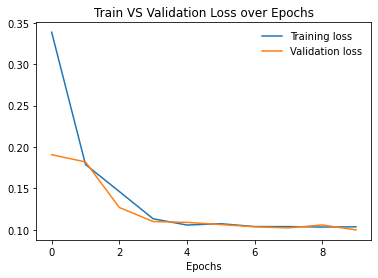

In [43]:
#inspired from: https://nbviewer.jupyter.org/github/FraPochetti/KagglePlaygrounds/blob/master/NYC%20Taxi%20Fares%20Prediction.ipynb 
# Train VS Validaton Loss

t = [np.mean(tloss[el]) for el in tloss]
v = [np.mean(vloss[el]) for el in vloss]

plt.plot(t, label='Training loss')
plt.plot(v, label='Validation loss')
plt.title("Train VS Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.legend(frameon=False)

In [44]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9914 entries, 0 to 9913
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Hour               9914 non-null   category
 1   AMorPM             9914 non-null   category
 2   Weekday            9914 non-null   category
 3   pickup_latitude    9914 non-null   float64 
 4   pickup_longitude   9914 non-null   float64 
 5   dropoff_latitude   9914 non-null   float64 
 6   dropoff_longitude  9914 non-null   float64 
 7   passenger_count    9914 non-null   float64 
 8   dist_km            9914 non-null   float64 
dtypes: category(3), float64(6)
memory usage: 572.5 KB


In [45]:
# divide to cats and conts columns + make them a tensor + to.cuda()

df_test_cats = df_test[['Hour', 'AMorPM', 'Weekday']]
test_cats = df_test_cats.astype(np.int64)
test_cats = torch.tensor(test_cats.values).cuda()

df_test_conts = df_test[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']]
test_conts = df_test_conts.astype(np.float32)
test_conts = torch.tensor(test_conts.values).cuda()

In [46]:
# make prediction

with torch.no_grad():
    model.eval()
    output = model.forward(test_cats,test_conts).cuda()

In [47]:
output

tensor([2.1298, 2.1895, 1.5211,  ..., 3.5912, 3.0065, 1.4597], device='cuda:0')

In [48]:
len(output)


9914

In [49]:
type(output)


torch.Tensor

In [50]:
np_output = output.cpu().numpy()


In [51]:
type(np_output)


numpy.ndarray

In [52]:
np_output


array([2.1298203, 2.189454 , 1.5211387, ..., 3.5911758, 3.0065162,
       1.4597132], dtype=float32)

In [53]:
np_output_exp = np.exp(np_output)


In [54]:
np_output_exp


array([ 8.413355 ,  8.930336 ,  4.5774345, ..., 36.276703 , 20.216846 ,
        4.3047247], dtype=float32)

In [55]:
df_output =  pd.DataFrame(np_output_exp)


In [56]:
df_output

,0
0,8.413355
1,8.930336
2,4.577435
3,6.288929
4,15.264206
...,...
9909,7.015420
9910,11.640455
9911,36.276703
9912,20.216846


In [57]:
type(df_output)


pandas.core.frame.DataFrame

In [58]:
df_output.to_csv('submission.csv', index=False)


In [59]:

from IPython.display import HTML
import base64

def create_download_link(df, title = "Download CSV file", filename = "submission.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)


In [60]:
create_download_link(df_output)